In [1]:
import os
import simba as si
si.__version__

'1.2'

In [2]:
workdir = 'result_simba_edge_weights'
si.settings.set_workdir(workdir)

Saving results in: result_simba_edge_weights


In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [4]:
# make plots prettier
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [5]:
adata_CG = si.datasets.rna_10xpmbc3k()

rna_10xpmbc3k.h5ad: 21.5MB [00:03, 5.60MB/s]                                               


Downloaded to result_simba_edge_weights/data.


In [6]:
adata_CG

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype'
    var: 'gene_ids'

In [7]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
2700 cells, 32738 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2700 cells, 13714 genes


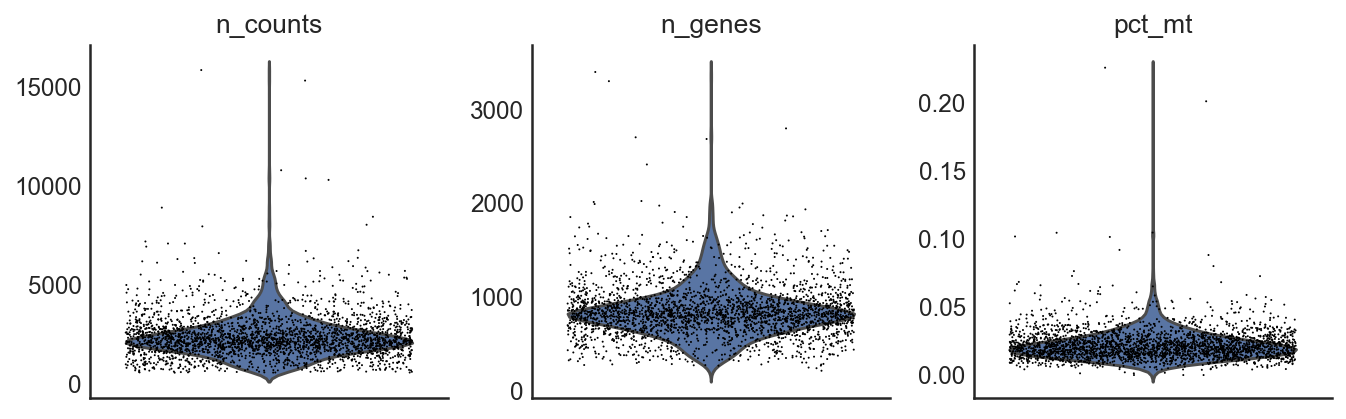

In [8]:
si.pp.cal_qc_rna(adata_CG)
si.pl.violin(adata_CG,list_obs=['n_counts','n_genes','pct_mt'])

In [9]:
si.pp.normalize(adata_CG,method='lib_size')
si.pp.log_transform(adata_CG)

2000 variable genes are selected.


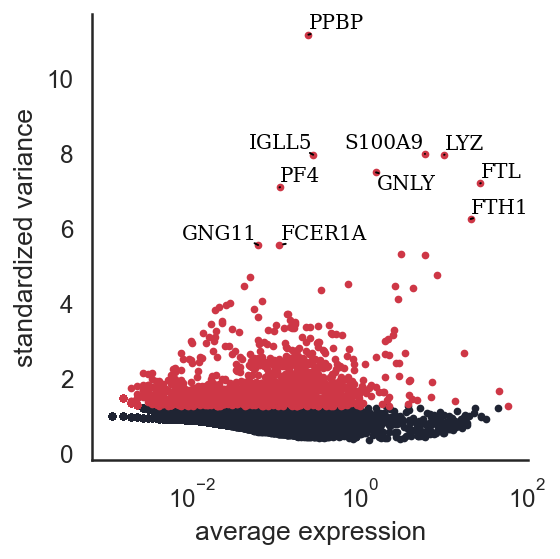

In [10]:
si.pp.select_variable_genes(adata_CG, n_top_genes=2000)
si.pl.variable_genes(adata_CG,show_texts=True)

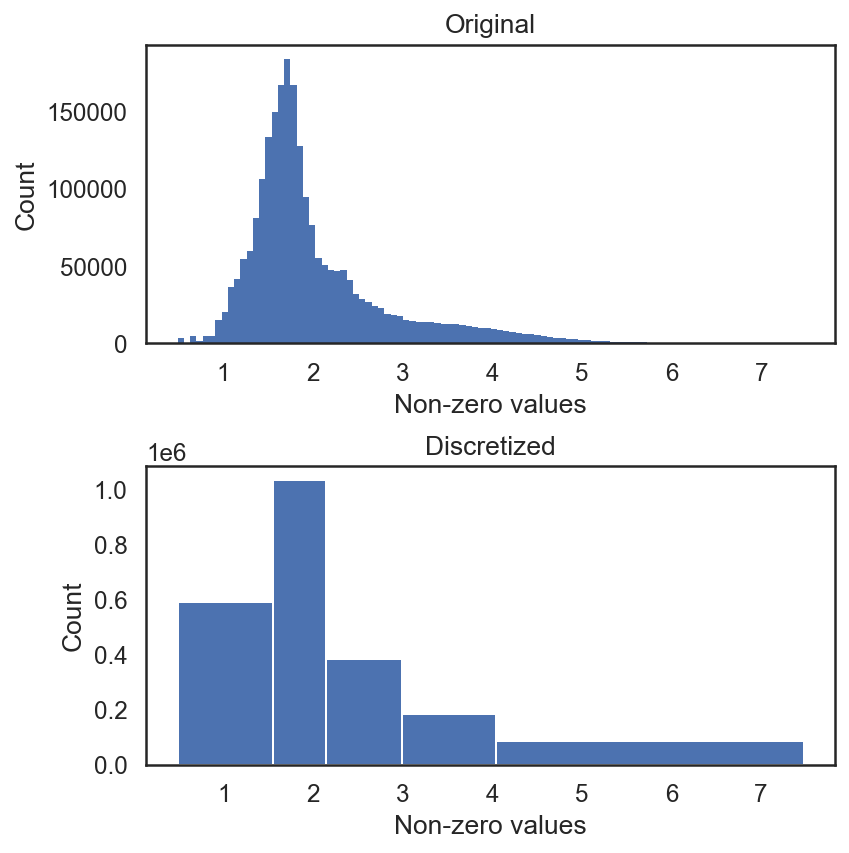

In [11]:
si.tl.discretize(adata_CG,n_bins=5)
si.pl.discretize(adata_CG,kde=False)

### Using discretized gene expression - all genes

In [12]:
si.tl.gen_graph(list_CG=[adata_CG],
                copy=False,
                use_highly_variable=False,
                layer='simba',
                add_edge_weights=False,
                dirname='graph0')

relation0: source: C, destination: G
#edges: 590134
relation1: source: C, destination: G
#edges: 1034817
relation2: source: C, destination: G
#edges: 384939
relation3: source: C, destination: G
#edges: 185485
relation4: source: C, destination: G
#edges: 87601
Total number of edges: 2282976
Writing graph file "pbg_graph.txt" to "result_simba_edge_weights/pbg/graph0" ...
Finished.


In [13]:
si.settings.pbg_params

{'entity_path': 'result_simba_edge_weights/pbg/graph0/input/entity',
 'edge_paths': ['result_simba_edge_weights/pbg/graph0/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1}, 'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r2', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.0,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'eval_num

In [14]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.015521
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 4 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model')

Auto-estimated weight decay is 0.015521
`.settings.pbg_params['wd']` has been updated to 0.015521
Converting input data ...
[2022-10-10 13:43:03.453400] Using the 5 relation types given in the config
[2022-10-10 13:43:03.453905] Searching for the entities in the edge files...
[2022-10-10 13:43:06.243132] Entity type C:
[2022-10-10 13:43:06.243681] - Found 2700 entities
[2022-10-10 13:43:06.244079] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:43:06.244885] - Left with 2700 entities
[2022-10-10 13:43:06.245435] - Shuffling them...
[2022-10-10 13:43:06.247549] Entity type G:
[2022-10-10 13:43:06.248129] - Found 13714 entities
[2022-10-10 13:43:06.248461] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:43:06.250226] - Left with 13714 entities
[2022-10-10 13:43:06.250876] - Shuffling them...
[2022-10-10 13:43:06.259329] Preparing counts and dictionaries for entities and relation types:
[2022-10-10 13:43:06.260700] - Writing count of entity type C a

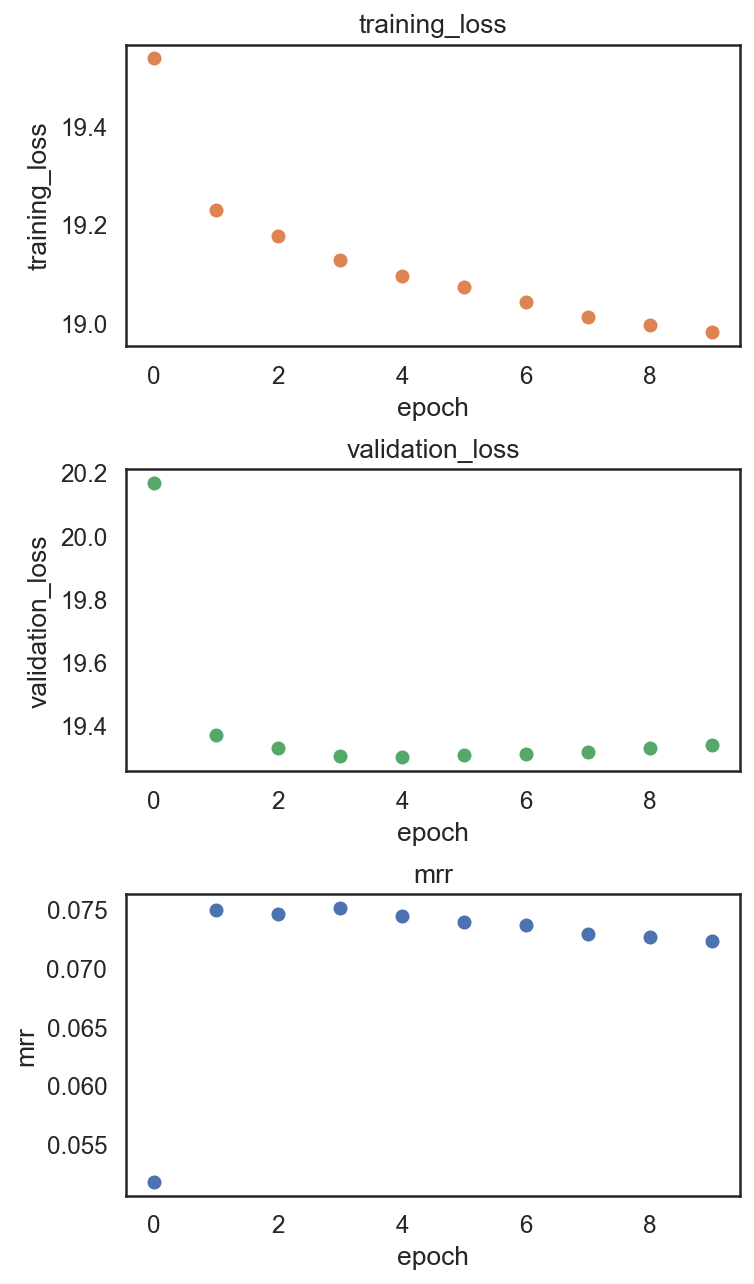

In [15]:
si.pl.pbg_metrics(fig_ncol=1)

In [16]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e',
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

dict_adata = si.read_embedding()

adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes

## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 2700 × 50
    obs: 'celltype'

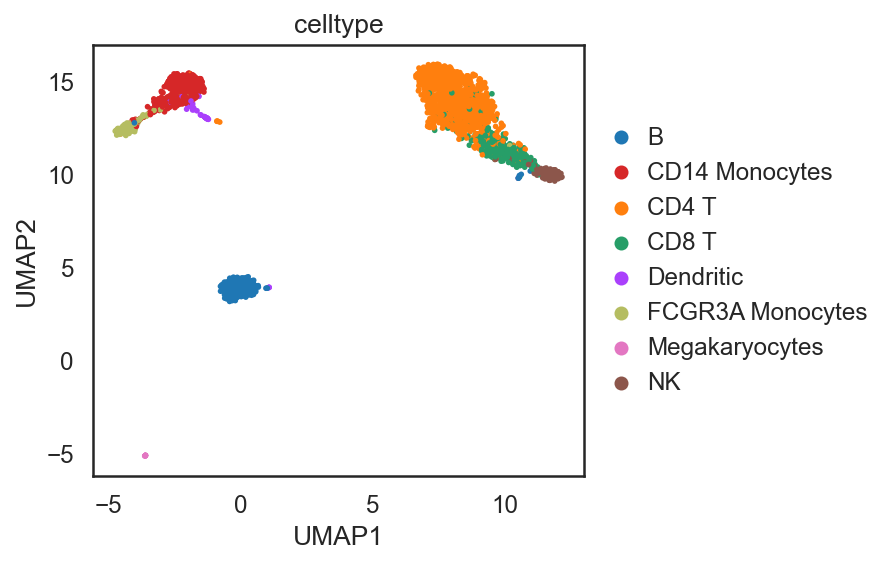

In [17]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(6,4),
           drawing_order='random')

### Using discretized gene expression - only variable genes

In [18]:
si.tl.gen_graph(list_CG=[adata_CG],
                copy=False,
                use_highly_variable=True,
                layer='simba',
                add_edge_weights=False,
                dirname='graph1')

relation0: source: C, destination: G
#edges: 138727
relation1: source: C, destination: G
#edges: 243405
relation2: source: C, destination: G
#edges: 82172
relation3: source: C, destination: G
#edges: 27876
relation4: source: C, destination: G
#edges: 17250
Total number of edges: 509430
Writing graph file "pbg_graph.txt" to "result_simba_edge_weights/pbg/graph1" ...
Finished.


In [19]:
si.settings.pbg_params

{'entity_path': 'result_simba_edge_weights/pbg/graph1/input/entity',
 'edge_paths': ['result_simba_edge_weights/pbg/graph1/input/edge'],
 'checkpoint_path': 'result_simba_edge_weights/pbg/graph0/model',
 'entities': {'C': {'num_partitions': 1}, 'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r2', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.015521,
 'wd_interval': 50,
 'eval_fraction

In [20]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 4 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model')

Auto-estimated weight decay is 0.069558
`.settings.pbg_params['wd']` has been updated to 0.069558
Converting input data ...
[2022-10-10 13:44:46.615190] Using the 5 relation types given in the config
[2022-10-10 13:44:46.615748] Searching for the entities in the edge files...
[2022-10-10 13:44:47.245409] Entity type C:
[2022-10-10 13:44:47.246209] - Found 2700 entities
[2022-10-10 13:44:47.246714] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:44:47.247570] - Left with 2700 entities
[2022-10-10 13:44:47.247964] - Shuffling them...
[2022-10-10 13:44:47.249921] Entity type G:
[2022-10-10 13:44:47.250608] - Found 2000 entities
[2022-10-10 13:44:47.250971] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:44:47.251637] - Left with 2000 entities
[2022-10-10 13:44:47.252242] - Shuffling them...
[2022-10-10 13:44:47.253708] Preparing counts and dictionaries for entities and relation types:
[2022-10-10 13:44:47.254991] - Writing count of entity type C and

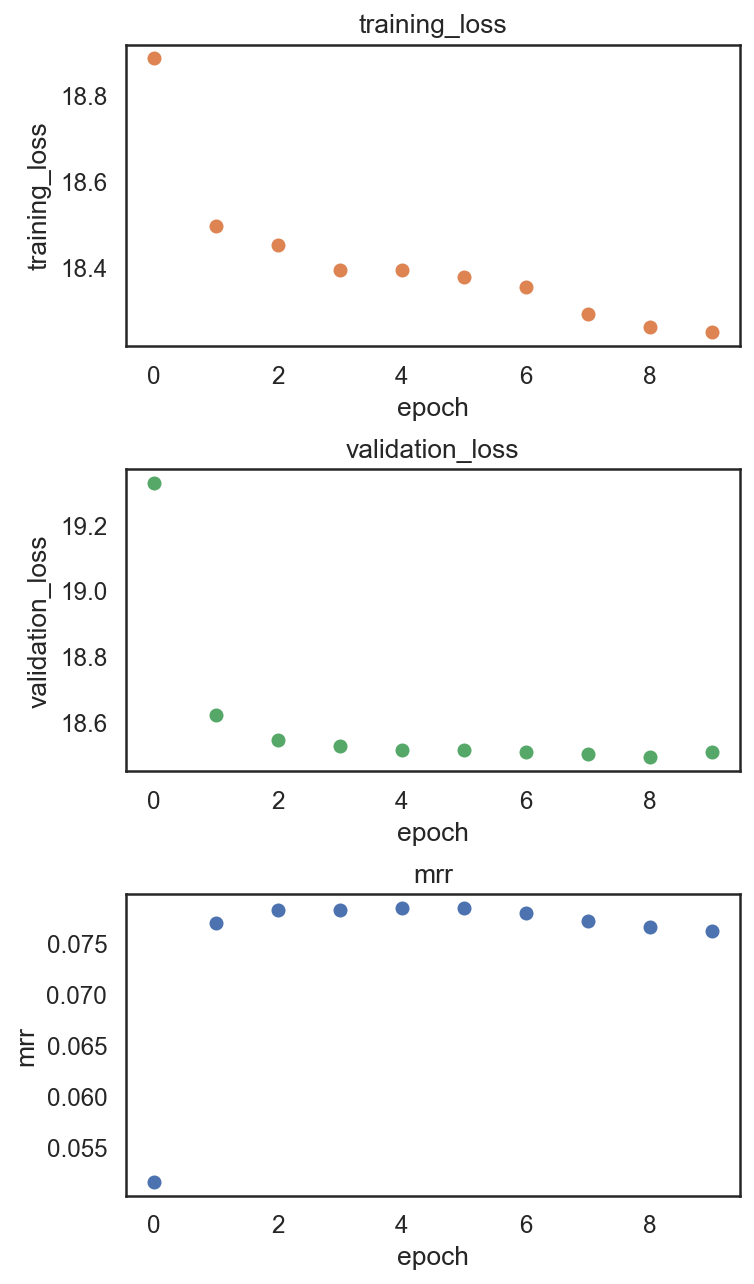

In [21]:
si.pl.pbg_metrics(fig_ncol=1)

In [22]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e',
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

dict_adata = si.read_embedding()

adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes

## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 2700 × 50
    obs: 'celltype'

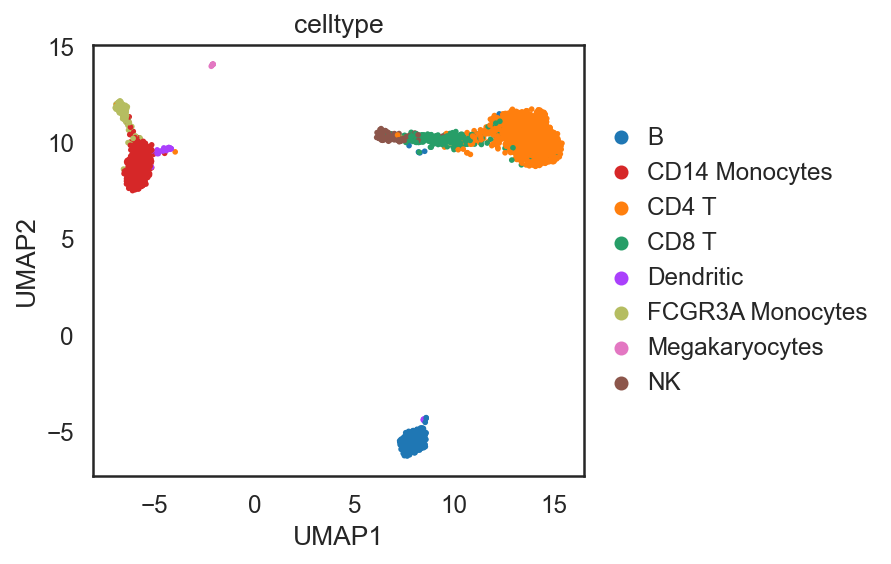

In [23]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(6,4),
           drawing_order='random')

### Using edge weights (raw gene expression) - all genes

In [24]:
si.tl.gen_graph(list_CG=[adata_CG],
                copy=False,
                use_highly_variable=False,
                layer=None,
                add_edge_weights=True,
                dirname='graph2')

relation0: source: C, destination: G
#edges: 2282976
Total number of edges: 2282976
Writing graph file "pbg_graph.txt" to "result_simba_edge_weights/pbg/graph2" ...
Finished.


In [25]:
si.settings.pbg_params

{'entity_path': 'result_simba_edge_weights/pbg/graph2/input/entity',
 'edge_paths': ['result_simba_edge_weights/pbg/graph2/input/edge'],
 'checkpoint_path': 'result_simba_edge_weights/pbg/graph1/model',
 'entities': {'C': {'num_partitions': 1}, 'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.069558,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'eval_num_uniform_negs': 50,
 'checkpoint_preservation_interval': None}

In [26]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 4 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model', use_edge_weights=True)

Auto-estimated weight decay is 0.015521
`.settings.pbg_params['wd']` has been updated to 0.015521
Converting input data ...
Edge weights are being used ...
[2022-10-10 13:47:20.130429] Using the 1 relation types given in the config
[2022-10-10 13:47:20.131066] Searching for the entities in the edge files...
[2022-10-10 13:47:23.633055] Entity type C:
[2022-10-10 13:47:23.633609] - Found 2700 entities
[2022-10-10 13:47:23.633978] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:47:23.634907] - Left with 2700 entities
[2022-10-10 13:47:23.635662] - Shuffling them...
[2022-10-10 13:47:23.637645] Entity type G:
[2022-10-10 13:47:23.638327] - Found 13714 entities
[2022-10-10 13:47:23.638688] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:47:23.641269] - Left with 13714 entities
[2022-10-10 13:47:23.641881] - Shuffling them...
[2022-10-10 13:47:23.654717] Preparing counts and dictionaries for entities and relation types:
[2022-10-10 13:47:23.656340] - 

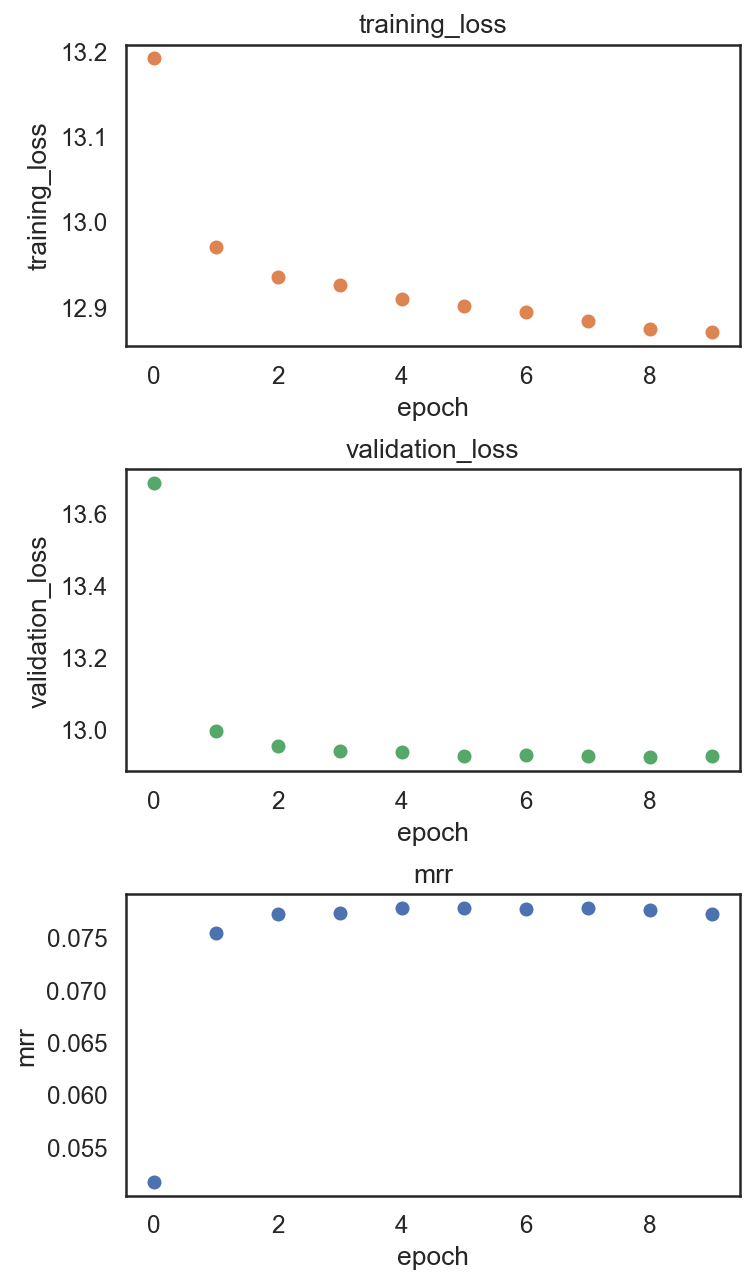

In [27]:
si.pl.pbg_metrics(fig_ncol=1)

In [28]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e',
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

dict_adata = si.read_embedding()

adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes

## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 2700 × 50
    obs: 'celltype'

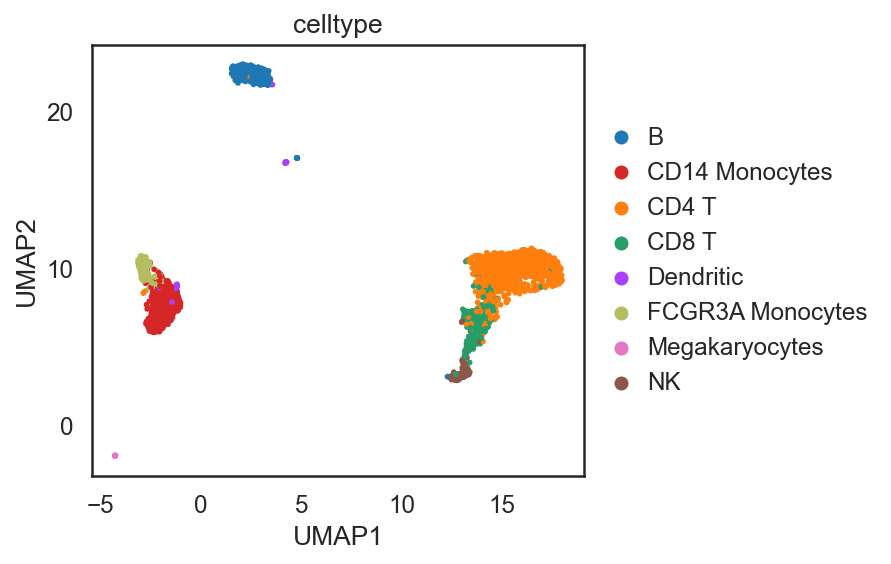

In [29]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(6,4),
           drawing_order='random')

### Using edge weights  (raw gene expression) - only variable genes

In [30]:
si.tl.gen_graph(list_CG=[adata_CG],
                copy=False,
                use_highly_variable=True,
                layer=None,
                add_edge_weights=True,
                dirname='graph3')

relation0: source: C, destination: G
#edges: 509430
Total number of edges: 509430
Writing graph file "pbg_graph.txt" to "result_simba_edge_weights/pbg/graph3" ...
Finished.


In [31]:
si.settings.pbg_params

{'entity_path': 'result_simba_edge_weights/pbg/graph3/input/entity',
 'edge_paths': ['result_simba_edge_weights/pbg/graph3/input/edge'],
 'checkpoint_path': 'result_simba_edge_weights/pbg/graph2/model',
 'entities': {'C': {'num_partitions': 1}, 'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.015521,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'eval_num_uniform_negs': 50,
 'checkpoint_preservation_interval': None}

In [32]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 4 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model', use_edge_weights=True)

Auto-estimated weight decay is 0.069558
`.settings.pbg_params['wd']` has been updated to 0.069558
Converting input data ...
Edge weights are being used ...
[2022-10-10 13:50:24.363063] Using the 1 relation types given in the config
[2022-10-10 13:50:24.363674] Searching for the entities in the edge files...
[2022-10-10 13:50:25.083892] Entity type C:
[2022-10-10 13:50:25.084614] - Found 2700 entities
[2022-10-10 13:50:25.085133] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:50:25.086340] - Left with 2700 entities
[2022-10-10 13:50:25.087150] - Shuffling them...
[2022-10-10 13:50:25.089147] Entity type G:
[2022-10-10 13:50:25.089771] - Found 2000 entities
[2022-10-10 13:50:25.090276] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:50:25.091244] - Left with 2000 entities
[2022-10-10 13:50:25.092002] - Shuffling them...
[2022-10-10 13:50:25.093553] Preparing counts and dictionaries for entities and relation types:
[2022-10-10 13:50:25.094980] - Wr

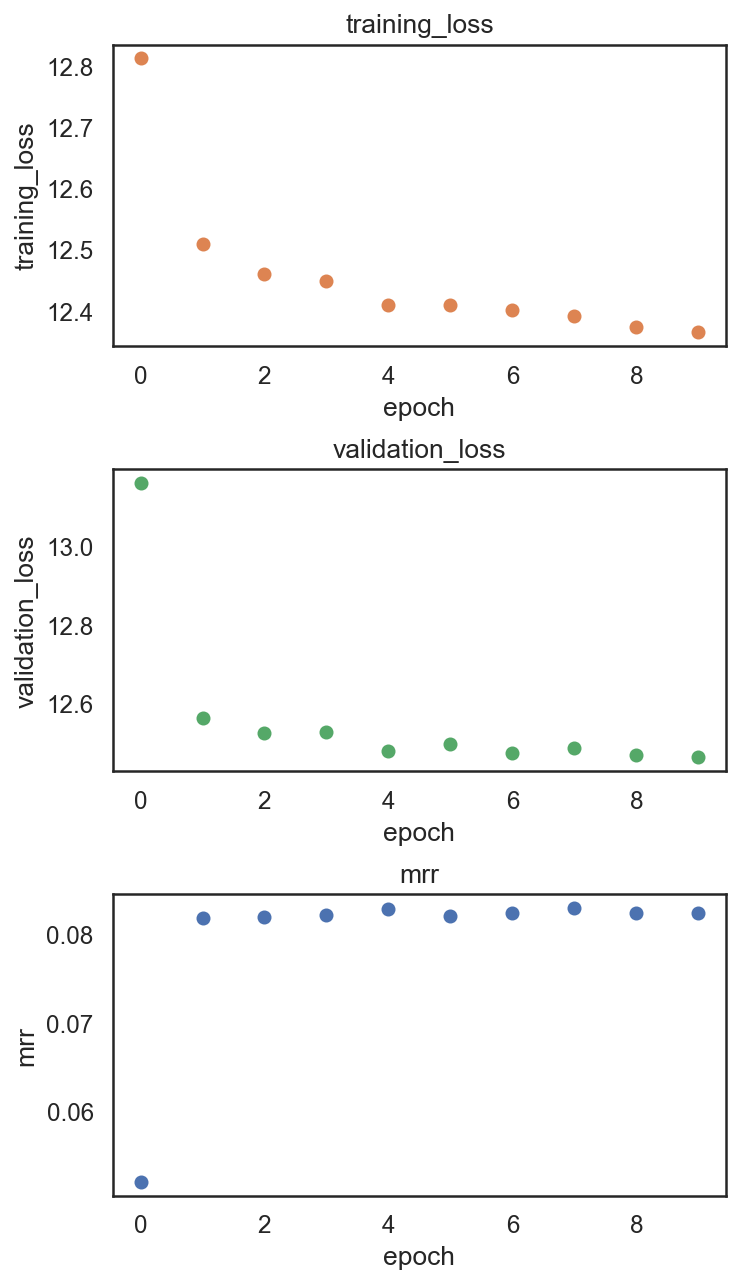

In [33]:
si.pl.pbg_metrics(fig_ncol=1)

In [34]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e',
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

dict_adata = si.read_embedding()

adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes

## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 2700 × 50
    obs: 'celltype'

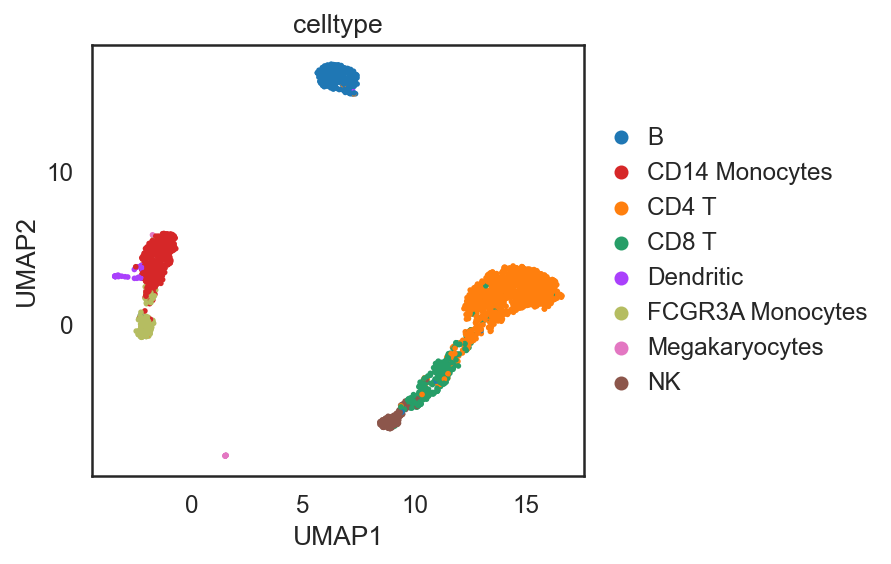

In [35]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(6,4),
           drawing_order='random')

### Using edge weights (discretized gene expression) - all genes

In [36]:
si.tl.gen_graph(list_CG=[adata_CG],
                copy=False,
                use_highly_variable=False,
                layer='simba',
                add_edge_weights=True,
                dirname='graph4')

relation0: source: C, destination: G
#edges: 2282976
Total number of edges: 2282976
Writing graph file "pbg_graph.txt" to "result_simba_edge_weights/pbg/graph4" ...
Finished.


In [37]:
si.settings.pbg_params

{'entity_path': 'result_simba_edge_weights/pbg/graph4/input/entity',
 'edge_paths': ['result_simba_edge_weights/pbg/graph4/input/edge'],
 'checkpoint_path': 'result_simba_edge_weights/pbg/graph3/model',
 'entities': {'C': {'num_partitions': 1}, 'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.069558,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'eval_num_uniform_negs': 50,
 'checkpoint_preservation_interval': None}

In [38]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 4 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model', use_edge_weights=True)

Auto-estimated weight decay is 0.015521
`.settings.pbg_params['wd']` has been updated to 0.015521
Converting input data ...
Edge weights are being used ...
[2022-10-10 13:53:33.429708] Using the 1 relation types given in the config
[2022-10-10 13:53:33.430294] Searching for the entities in the edge files...
[2022-10-10 13:53:36.640605] Entity type C:
[2022-10-10 13:53:36.641172] - Found 2700 entities
[2022-10-10 13:53:36.641698] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:53:36.642450] - Left with 2700 entities
[2022-10-10 13:53:36.643278] - Shuffling them...
[2022-10-10 13:53:36.645758] Entity type G:
[2022-10-10 13:53:36.646605] - Found 13714 entities
[2022-10-10 13:53:36.647252] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:53:36.651858] - Left with 13714 entities
[2022-10-10 13:53:36.652631] - Shuffling them...
[2022-10-10 13:53:36.665425] Preparing counts and dictionaries for entities and relation types:
[2022-10-10 13:53:36.666976] - 

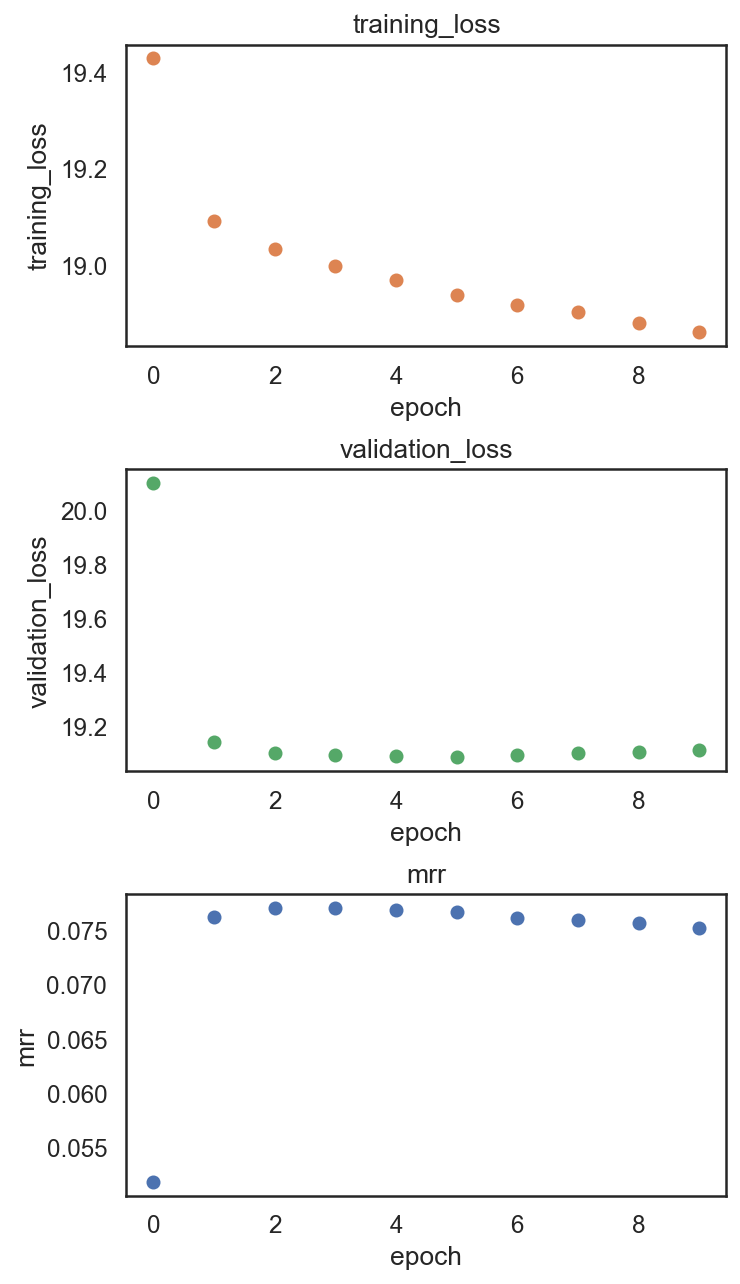

In [39]:
si.pl.pbg_metrics(fig_ncol=1)

In [40]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e',
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

dict_adata = si.read_embedding()

adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes

## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 2700 × 50
    obs: 'celltype'

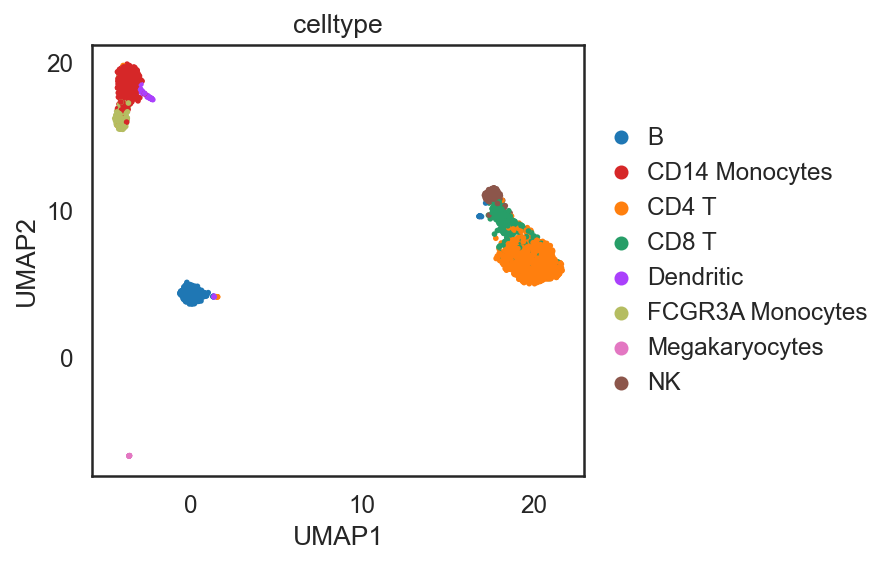

In [41]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(6,4),
           drawing_order='random')

### Using edge weights  (discretized gene expression) - only variable genes

In [43]:
si.tl.gen_graph(list_CG=[adata_CG],
                copy=False,
                use_highly_variable=True,
                layer='simba',
                add_edge_weights=True,
                dirname='graph5')

relation0: source: C, destination: G
#edges: 509430
Total number of edges: 509430
Writing graph file "pbg_graph.txt" to "result_simba_edge_weights/pbg/graph5" ...
Finished.


In [44]:
si.settings.pbg_params

{'entity_path': 'result_simba_edge_weights/pbg/graph5/input/entity',
 'edge_paths': ['result_simba_edge_weights/pbg/graph5/input/edge'],
 'checkpoint_path': 'result_simba_edge_weights/pbg/graph4/model',
 'entities': {'C': {'num_partitions': 1}, 'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.015521,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'eval_num_uniform_negs': 50,
 'checkpoint_preservation_interval': None}

In [45]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 4 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model', use_edge_weights=True)

Auto-estimated weight decay is 0.069558
`.settings.pbg_params['wd']` has been updated to 0.069558
Converting input data ...
Edge weights are being used ...
[2022-10-10 13:57:37.849447] Using the 1 relation types given in the config
[2022-10-10 13:57:37.849988] Searching for the entities in the edge files...
[2022-10-10 13:57:38.531957] Entity type C:
[2022-10-10 13:57:38.532530] - Found 2700 entities
[2022-10-10 13:57:38.532959] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:57:38.533803] - Left with 2700 entities
[2022-10-10 13:57:38.534463] - Shuffling them...
[2022-10-10 13:57:38.536572] Entity type G:
[2022-10-10 13:57:38.537305] - Found 2000 entities
[2022-10-10 13:57:38.537740] - Removing the ones with fewer than 1 occurrences...
[2022-10-10 13:57:38.538544] - Left with 2000 entities
[2022-10-10 13:57:38.539200] - Shuffling them...
[2022-10-10 13:57:38.540654] Preparing counts and dictionaries for entities and relation types:
[2022-10-10 13:57:38.542192] - Wr

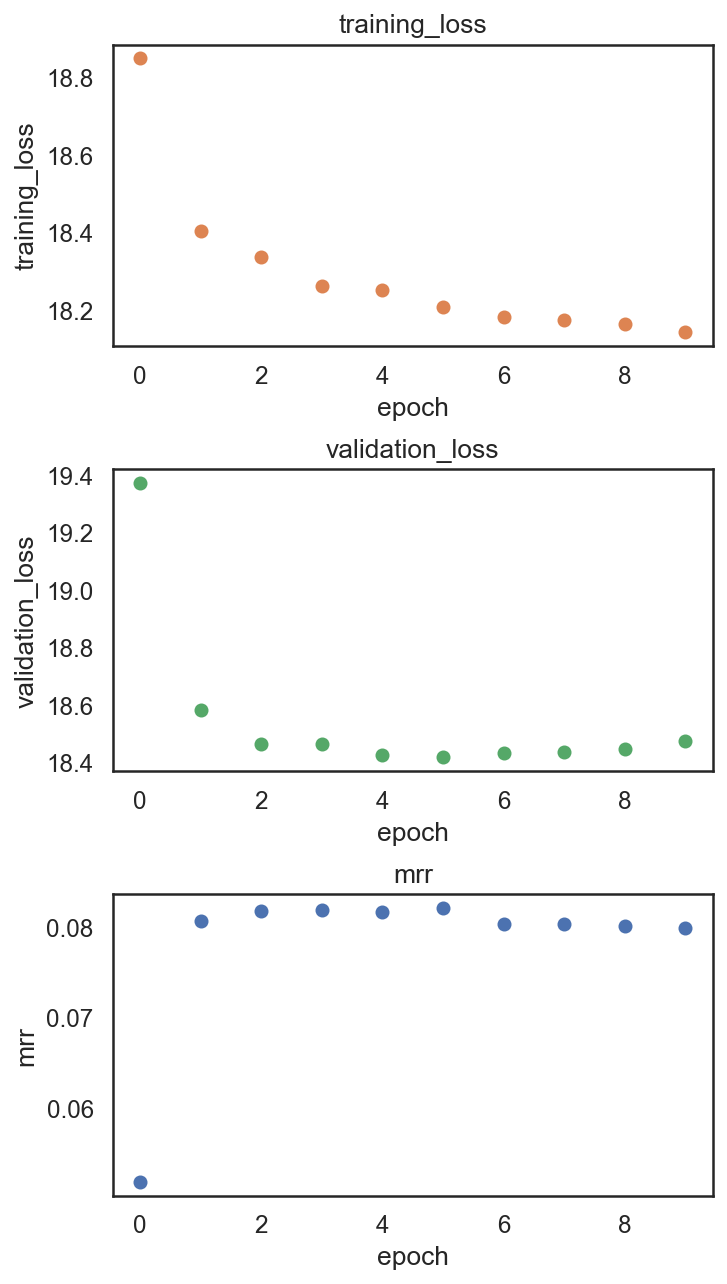

In [46]:
si.pl.pbg_metrics(fig_ncol=1)

In [47]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e',
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

dict_adata = si.read_embedding()

adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes

## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 2700 × 50
    obs: 'celltype'

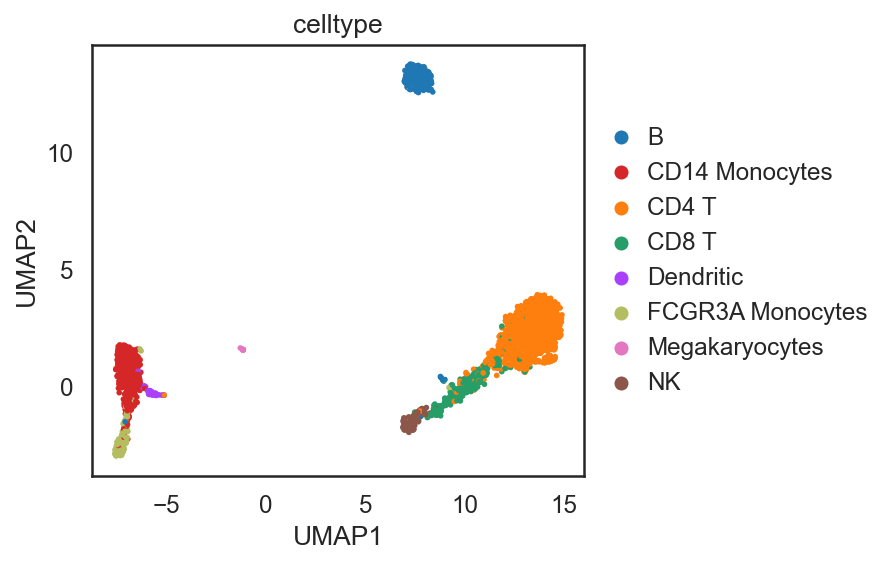

In [48]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(6,4),
           drawing_order='random')